In [0]:
import numpy as np
import sklearn
import networkx as nx
from matplotlib import pyplot as plt
from shapely.geometry import Polygon
import sys
sys.setrecursionlimit(10**6) 

np.random.seed(42)

In [2]:
!pip install gtsam

     |████████████████████████████████| 7.8MB 3.0MB/s 


In [0]:
from mobileManipulator import FourLinkMM
import gtsam
import gtsam.utils.plot as gtsam_plot
from gtsam import Pose2
from utils import *

In [0]:
def RandomQ(Qgoal, arm, obstacles):
    pi = 3.14
    t1 = 0
    t2 = 0
    t3 = 0
    t4 = 0
    if np.random.randn() <= 0.15: #15% probability that it returns Qgoal
        print('HIT GOAL')
        return Qgoal
    collision = True
    while collision:      
        #Each t[i] ranges from -180 to 180
        t1 = np.random.rand()*360-180
        t2 = np.random.rand()*360-180
        t3 = np.random.rand()*360-180
        t4 = np.random.rand()*360-180
        q = np.radians(vector4(t1, t2, t3, t4))
        sTt_ee = arm.fwd_kinematics(q)
        sTt_b, qdash = arm.ik2(sTt_ee, obstacles)
        collision = arm.check_collision_with_obstacles(obstacles, sTt_b, q) #colliding with obstacle
           
    return [t1,t2,t3,t4]

In [0]:
class Node_manip():
  def __init__(self, idx, Q, dictionary, G):
    self.idx = idx
    self.t1 = Q[0]
    self.t2 = Q[1]
    self.t3 = Q[2]
    self.t4 = Q[3]
    self.neighbors = []
    self.parent = None
    dictionary[idx] = Q
    G.add_node(idx)

In [0]:
class Tree_manip():
  def __init__(self, curr_iter, curr_node):
    self.root = curr_node

  def find_dist(self, q0, q1):
    if type(q0) is list:
      #print('compare',q0, q1)
      val1 = q0[0] - q1[0]
      val2 = q0[1] - q1[1]
      val3 = q0[2] - q1[2]
      val4 = q0[3] - q1[3]
    else:
      #print('compare',[q0.t1, q0.t2, q0.t3, q0.t4], q1)
      val1 = q0.t1-q1[0]
      val2 = q0.t2-q1[1]
      val3 = q0.t3-q1[2]
      val4 = q0.t4-q1[3]
    dist_val = np.sqrt(np.square(val1)+np.square(val2)+np.square(val3)+np.square(val4))
    return dist_val
  
  def find_neighbors(self, q, dictionary, radius):
    costs = {}
    Xbest = None
    min_cost = 10000000

    for i in range(len(dictionary)):
      q0 = dictionary[i]
      c = self.find_dist(q0, q)
      #print(q0)

      if c <= radius:
        costs[i] = c
      if c < min_cost:
        Xbest = q0
        min_cost = c
    return Xbest, costs

  def iterate(self, q, qc, dictionary):
    min_val = 1000000
    explore = None
    for i in range(len(dictionary)):
      dval = self.find_dist(qc, dictionary[i])
      if dval < min_val:
        min_val = dval
        explore = dictionary[i]
    return min_val, explore
    
  def iterate2(self, q, qc):
    #print('check this', q)
    if q == None or q.neighbors == []: #no neighbors
      return 10000, q
    #print('look here',q.idx,q,q.neighbors[0].idx)
    
    m1 = 1000000
    e1 = None

    for i in range(len(q.neighbors)):
      new_dist = self.find_dist(q.neighbors[i], qc)

      if new_dist < m1:
        e1 = q.neighbors[i]
        m1 = new_dist

      #explore neighbor 
      m2, e2 = self.iterate(e1, qc)
      if m2 < m1:
        m1 = m2 
        e1 = e2

    return m1, e1

  def steer(self, Q_curr, Q_new, step_size):
    q1 = np.asarray(Q_curr)
    q2 = np.asarray(Q_new) #go in direction of q2
    q_sub = np.subtract(q2,q1)
    q_dir = q_sub/np.linalg.norm(q_sub)
    q_dir *= step_size

    q_new = q1+q_dir
    q_steer = [q_new[0], q_new[1], q_new[2], q_new[3]]
    return q_steer

  def link(self, q1, q2, G):
    if q2 not in q1.neighbors:
      q1.neighbors.append(q2)
      q2.parent = q1
      G.add_edge(q1.idx, q2.idx)
    return

  def find_closest(self, Q_curr, dictionary):
    ##print('SEARCHING', Q_curr)
    min_dist, explore = self.iterate(self.root, Q_curr, dictionary)
    return explore, min_dist

In [0]:
def check_for_collision(xnear, xnew, step_size, lim):
  q1 = np.asarray(xnear)
  q2 = np.asarray(xnew)
  qdiff = q2-q1
  q_dir = qdiff/np.linalg.norm(qdiff)

  q = q1
  collision = False
  while abs(q[0]-q1[0]) > lim or abs(q[1]-q1[1]) > lim or abs(q[2]-q1[2]) > lim or abs(q[3]-q1[3]) > lim:
    q += step_size*q_dir

    #check for collision
    sTt_ee = arm.fwd_kinematics(q)
    sTt_b, qdash = arm.ik2(sTt_ee, obstacles)
    collision = arm.check_collision_with_obstacles(obstacles, sTt_b, q)

    if collision == True:
      return True
  return False

In [0]:
def find_idx_by_node(all_nodes, q):
  for i in range(len(all_nodes)):
    qb = all_nodes[i]
    qb_b = [qb.t1, qb.t2, qb.t3, qb.t4]
    if qb_b == q:
      return qb.idx
  return -1

In [0]:
def search_node(all_nodes, idx):
  for i in range(len(all_nodes)):
    if all_nodes[i].idx == idx:
      return all_nodes[i]

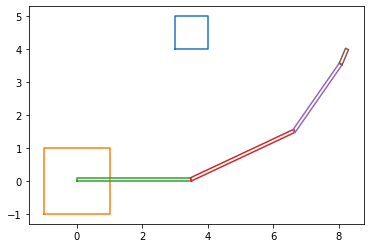

In [11]:
arm = FourLinkMM()
obstacles = [Polygon([(3,4), (3, 5), (4, 5), (4,4)])]
base, link_1, link_2, link_3, link_4 = arm.create_manipulator_model(Pose2(0, 0, 0), np.radians(vector4(0, 25, 30, 12)))
plt.figure()
plt.plot(*obstacles[0].exterior.xy)
plt.plot(*base.exterior.xy)
plt.plot(*link_1.exterior.xy)
plt.plot(*link_2.exterior.xy)
plt.plot(*link_3.exterior.xy)
plt.plot(*link_4.exterior.xy)
plt.show()

In [45]:
num_iters = 1000
step_size = 3

dictionary = {}
Qstart = [0,0,0,0]
Qgoal = [0,25,30,12]
curr_iter = 1
G = nx.Graph()
lim = 15 #The robot can stop at a configuration (q1,q2,q3,q4) where q[i] is at most 15 degrees away from Qgoal[i]

root = Node_manip(0, Qstart, dictionary, G)
graph = Tree_manip(0, root)

till_now = [Qstart]
curr_node = root

radius = 40
init_cost = {}
init_cost[0]=0

all_nodes = []
all_nodes.append(root)

while curr_iter < num_iters:
  if curr_iter%100 == 0:
    print(curr_iter,'iterations completed')
  pos = RandomQ(Qgoal, arm, obstacles) 
  
  q = np.radians(vector4(pos[0], pos[1], pos[2], pos[3]))
  c0 = [curr_node.t1, curr_node.t2, curr_node.t3, curr_node.t4]

  c1, min_dist =graph.find_closest(pos, dictionary) #xnearest
  #[nearest_node.t1, nearest_node.t2, nearest_node.t3, nearest_node.t4]
  nearest_node_idx = find_idx_by_node(all_nodes, c1)
  nearest_node = all_nodes[nearest_node_idx]


  steer_node = graph.steer(c1, pos, step_size) #xnew

  Xbest, costs = graph.find_neighbors(steer_node, dictionary, radius)

  #if Xbest == None: #No node found in that radius
  #  steer_node = graph.steer(nearest_node, pos, step_size)
  #else:
  #  #print('works')
  #  steer_node = graph.steer(Xbest, pos, step_size)

  collision = check_for_collision(c1, steer_node, step_size, 3)
  if collision == False:
    add_node = Node_manip(curr_iter, steer_node, dictionary, G) #add xnew to graph
    all_nodes.append(add_node)
    init_cost[curr_iter] = graph.find_dist(root, steer_node)
  #graph.link(nearest_node, add_node, G)

    cval = 10000000
    node_id = -1
    xmin = c1 #nearest_node
    for idx in costs:
      qn = dictionary[idx]

      collision = check_for_collision(qn, steer_node, step_size, 3) #xnear, xnew
      if collision == False:
        cval = init_cost[idx] +  graph.find_dist(qn, steer_node)
        #print('compare:',init_cost[idx],dictionary[idx], cval, init_cost[curr_iter])
        if cval < init_cost[curr_iter]: #steernode
          xmin = qn
          node_id = idx

    if node_id == -1: 
      graph.link(add_node, nearest_node, G)
      #print('look here', c1, steer_node, pos)
    else:
      qn_node = search_node(all_nodes, node_id)
      graph.link(add_node, qn_node, G)

    for idx in costs:
      qn = dictionary[idx]
      if idx == node_id:
        continue
      collision = check_for_collision(qn, steer_node, step_size, 3) 
      if collision == False and init_cost[idx] > init_cost[curr_iter]+graph.find_dist(qn, steer_node):
        graph.link(qn, steer_node, G)
        q_node = search_node(all_nodes, idx)
        xparent = qn_node.parent
        parent_idx = find_idx_by_node(all_nodes, xparent)
        G.remove_edge(parent_idx, idx)
    #if min_dist + graph.find_dist(qn, pos) < costs[idx]:
    #  curr_iter += 1
    #  cost[idx] = min_dist + graph.find_dist(qn, pos)
    #  new_steer_node = graph.steer(qn, pos, step_size)
    #  new_add_node = Node_manip(curr_iter, new_steer_node, dictionary, G)
    #  graph.link(qn, new_add_node, G)


    curr_node = add_node
    curr_iter += 1

  #print(till_now)
    till_now.append(steer_node)
    add = [add_node.t1, add_node.t2, add_node.t3, add_node.t4]
  #print('over here', pos, c1, add, graph.find_dist(add, Qgoal))
    #print('add',add,c1,Qgoal,graph.find_dist(add,Qgoal))
    if abs(add[0] -Qgoal[0]) <= lim and abs(add[1]-Qgoal[1]) <= lim and abs(add[2]-Qgoal[2]) <= lim and abs(add[3]-Qgoal[3]) <= lim:
      print("reached goal")
      break
#print(curr_iter)

HIT GOAL
HIT GOAL
HIT GOAL
HIT GOAL
HIT GOAL
HIT GOAL
reached goal


In [0]:
v_path = nx.algorithms.shortest_path(G, root.idx, add_node.idx)
print('Vertices for shortest path:',v_path)

path = []
for p in v_path:
  path.append(dictionary[p])
print('Actual path:',path)

Vertices for shortest path: [0, 1, 4, 5, 7, 8, 9, 10, 11]
Actual path: [[0, 0, 0, 0], [1.9298341953398226, -1.1476194750787523, 0.4359383050551553, -1.9413055692246668], [0.0, 1.8358326736802424, 2.202999208416291, 0.8811996833665164], [0.0, 3.6716653473604848, 4.405998416832582, 1.7623993667330329], [0.0, 5.507498021040727, 6.608997625248874, 2.6435990500995494], [0.0, 7.3433306947209696, 8.811996833665164, 3.5247987334660658], [0.0, 9.179163368401213, 11.014996042081455, 4.405998416832582], [0.0, 11.014996042081455, 13.217995250497745, 5.287198100199099], [0.0, 12.850828715761697, 15.420994458914036, 6.168397783565615]]
